In [1]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# df = pd.read_csv(r'D:/Course/FirstSemester/GHPIM/GHPIM_med/nhanes_metSyn_20220316.csv')
df = pd.read_csv('./nhanes_metSyn_20220316.csv')
df = pd.DataFrame(columns = df.columns.tolist(), data = df)
df.columns.tolist()

for i in df.columns:
    if i not in 'ckd':
        df[i] = df[i].fillna(df[i].mean())
df['ckd'] = df['ckd'].fillna(0)

df.head()

,SEQN,ATP_MS,IDF_MS,race,sex,AGE,WT,BMI,height,WAIST,waist_hip_ratio,BMPTRI,BMPSUB,BMPSUP,BMPTHI,HR,SBP,DBP,HB,HCT,PLT,TCHO,TG,LDL,HDL,ApoA,ApoB,fibriongen,CRP,uric_acid,GLU,BUN,T_bilirubin,Creatinine,GOT,GPT,diabetes_told,insulin,oral_hypoglycemic_agent,anti_hypertensive,Smoking,MDRD_eGFR,ckd,followupmonth,allcausedeath
0,9,1.0,1,1,0,48,68.05,27.6,156.9,89.50000,0.840000,34.80000,38.000000,22.600000,41.900000,76.0,131.0,73.0,13.1,36.95,235.5,236.0,98.0,150.0,66.0,166.0,111.0,268.0,0.21,5.0,109.0,14.0,0.4,0.8,15.0,13.0,0,0,0,0,0,81.37,0.0,129.0,0.0
1,34,0.0,0,2,0,42,57.20,22.6,159.0,70.20000,0.750000,18.30000,14.700000,8.000000,21.200000,76.0,100.0,67.0,11.0,35.30,375.5,216.0,57.0,148.0,57.0,171.0,110.0,372.0,0.21,3.6,88.0,15.0,0.3,0.8,15.0,5.0,0,0,0,0,1,101.16,0.0,126.0,0.0
2,49,0.0,0,1,0,82,43.63,19.1,151.2,94.97822,0.941085,18.16093,20.728008,21.130681,20.697967,64.0,177.0,65.0,10.0,32.35,151.5,179.0,110.0,106.0,51.0,153.0,95.0,331.0,0.21,4.1,80.0,29.0,0.3,1.2,20.0,9.0,1,0,0,0,0,45.71,1.0,39.0,1.0
3,51,0.0,0,3,1,44,144.50,44.4,180.5,144.70000,1.080000,19.40000,20.728008,33.900000,20.697967,92.0,130.0,86.0,16.1,49.80,185.0,162.0,89.0,87.0,57.0,146.0,82.0,350.0,0.21,7.6,93.0,15.0,0.7,1.2,44.0,38.0,0,0,0,0,1,69.91,0.0,144.0,0.0
4,63,0.0,0,3,0,66,56.90,23.6,155.3,81.80000,0.910000,21.50000,18.700000,13.000000,21.500000,60.0,137.0,73.0,13.3,40.60,281.0,202.0,96.0,130.0,53.0,158.0,104.0,333.0,0.44,4.7,106.0,14.0,0.5,1.0,20.0,9.0,1,0,0,0,0,58.96,1.0,113.0,0.0


In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve,auc,mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

def CrossValidation(model,x,y,cv):
    k_fold=KFold(n_splits=cv,shuffle=False)
    acc_list=[]
    for i,(train_index,val_index) in enumerate(k_fold.split(x),start=1):
        model.fit(x[train_index],y[train_index].ravel())
        y_pred  = model.predict(x[val_index])
        acc_list.append(model.score(x[val_index],y[val_index]))
    return round(sum(acc_list)/cv,2)

def PlotRocCurve(y_labels,y_pre,plt_title,label):
    fpr,tpr,thresholds=roc_curve(y_labels,y_pre)
    auc_data=auc(fpr,tpr)
    plt.plot(fpr, tpr, label=label, lw=2)
    plt.title(plt_title)
    plt.ylabel('sensitivity')
    plt.xlabel('1-specificity')
    plt.legend(loc='lower right')
    return round(auc_data,2)

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df.drop('allcausedeath',axis=1).drop('SEQN',axis=1).drop('ApoB',axis=1).drop('ApoA',axis=1).drop('insulin',axis=1).drop('oral_hypoglycemic_agent', axis=1).drop('followupmonth', axis=1).values
y = df['allcausedeath'].values.reshape(-1, 1).astype('int')



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print('Training data shape:', X_train.shape)
print('Testing data shape:', X_test.shape)


Training data shape: (2516, 38)
Testing data shape: (280, 38)


訓練集 Score:  0.9937244480293786
測試集 Score:  0.26130607076833556


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


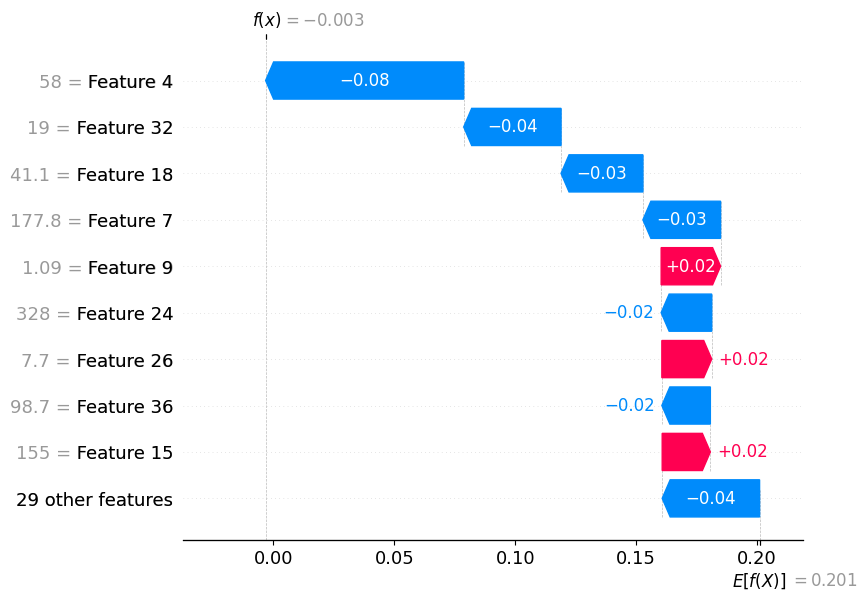

In [4]:
from xgboost import XGBRegressor
import shap



xgboostModel = XGBRegressor()

xgboostModel.fit(X_train, y_train)

predicted = xgboostModel.predict(X_train)

print("訓練集 Score: ", xgboostModel.score(X_train,y_train))
print("測試集 Score: ", xgboostModel.score(X_test,y_test))


explainer = shap.Explainer(xgboostModel)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])


In [5]:
# shap.plots.force(explainer.expected_value, shap_values.values,shap_values.data)

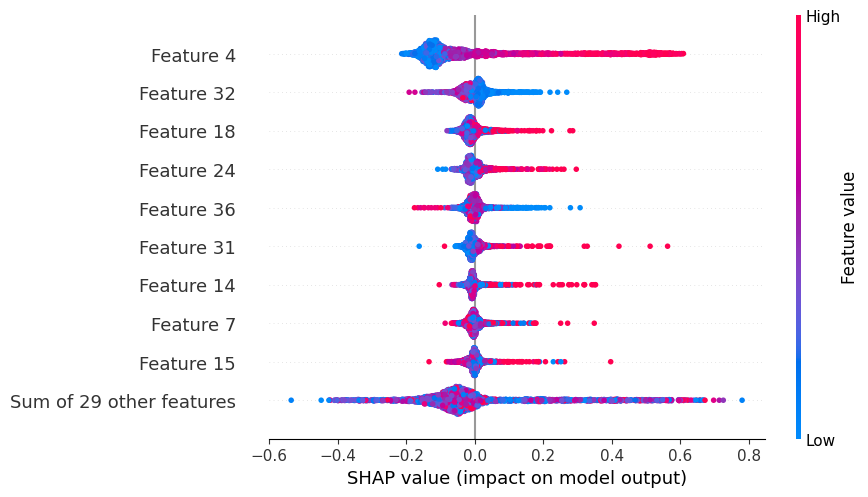

In [6]:
shap.plots.beeswarm(shap_values)

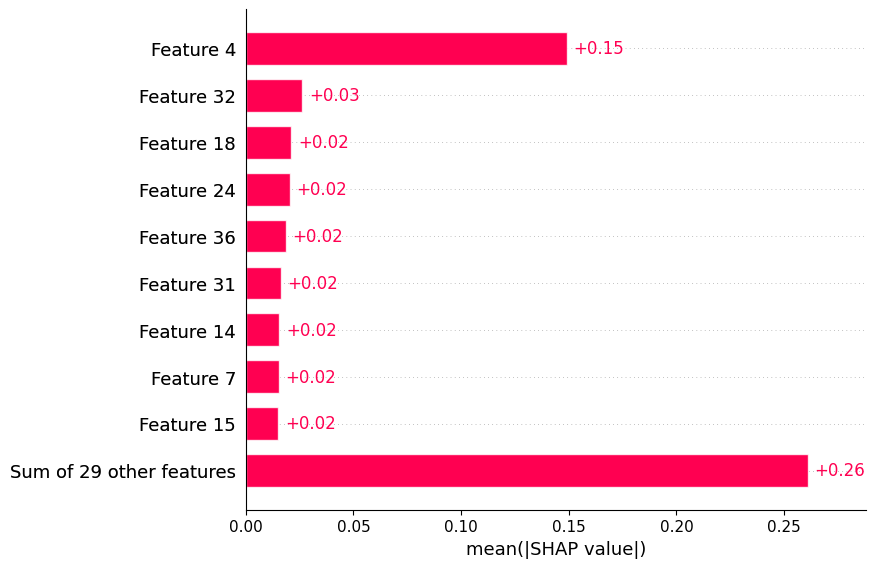

In [7]:
shap.plots.bar(shap_values)

In [8]:
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import confusion_matrix


logistic = LogisticRegression(solver='lbfgs',max_iter=4000)
logistic.fit(X_train, y_train.ravel())

predicted = logistic.predict(X_train)
# ROC AUC
LogisticRegression_Cv=CrossValidation(logistic,X_train,y_train,cv=10)

print("LogisticRegression")
print("訓練集 Score: ", round(logistic.score(X_train,y_train),2))
print("測試集 Score: ", round(logistic.score(X_test,y_test),2))
print('交叉驗證: ',round(LogisticRegression_Cv,2))

LogisticRegression
訓練集 Score:  0.86
測試集 Score:  0.83
交叉驗證:  0.85


In [9]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(is_unbalance=True)
lgb_model.fit(X_train,y_train.ravel())
pred=lgb_model.predict(X_test)

LGBMClassifier_Cv=CrossValidation(lgb_model,X_train,y_train,cv=10)


print("LGBMClassifier")
print("訓練集 Score: ", round(lgb_model.score(X_train,y_train),2))
print("測試集 Score: ", round(lgb_model.score(X_test,y_test),2))
print("交叉驗證: ",LGBMClassifier_Cv)

LGBMClassifier
訓練集 Score:  0.98
測試集 Score:  0.82
交叉驗證:  0.85


In [10]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train.ravel())

xgboostModel = XGBClassifier(n_estimators=100, learning_rate= 0.3)

xgboostModel.fit(X_train, y_train.ravel())

XGBClassifier_Cv=CrossValidation(xgboostModel,X_train,y_train,cv=10)

print("XGBClassifer")
print('訓練集: ',round(xgboostModel.score(X_train,y_train),2))
print('測試集: ',round(xgboostModel.score(X_test,y_test),2))
print(f"交叉驗證:{XGBClassifier_Cv} ")


XGBClassifer
訓練集:  0.98
測試集:  0.85
交叉驗證:0.85 


In [11]:
from sklearn import ensemble
bag = ensemble.BaggingClassifier(n_estimators = 100)
bag_fit = bag.fit(X_train, y_train)

# 預測
test_y_predicted = bag.predict(X_test)
# ROC AUc
BaggingClassifier_Cv=CrossValidation(bag,X_train,y_train,cv=10)
# 績效
print("EnsembleLearning(bagging)")
print('訓練集: ',round(bag.score(X_train,y_train),2))
print('測試集: ',round(bag.score(X_test,y_test),2))
print('交叉驗證: ',round(BaggingClassifier_Cv,2))

EnsembleLearning(bagging)
訓練集:  0.98
測試集:  0.85
交叉驗證:  0.85


In [14]:
from sklearn import ensemble


ada_boost = ensemble.AdaBoostClassifier(n_estimators = 100)
boost_fit = ada_boost.fit(X_train, y_train)

# 預測
test_y_predicted = ada_boost.predict(X_test)

# ROC AUC
AdaBoostClassifier_Cv=CrossValidation(ada_boost,X_train,y_train,cv=10)

# 績效
print("AdaBoostClassifier")
print('訓練集: ',round(ada_boost.score(X_train,y_train),2))
print('測試集: ',round(ada_boost.score(X_test,y_test),2))
print("交叉驗證: ",round(AdaBoostClassifier_Cv,2))

AdaBoostClassifier
訓練集:  0.88
測試集:  0.82
交叉驗證:  0.84


Logistic_AUC:0.81
LGBM_AUC:0.79
Bagging_AUC:0.82
XGBoost_AUC:0.8
AdaBoost_AUC:0.77


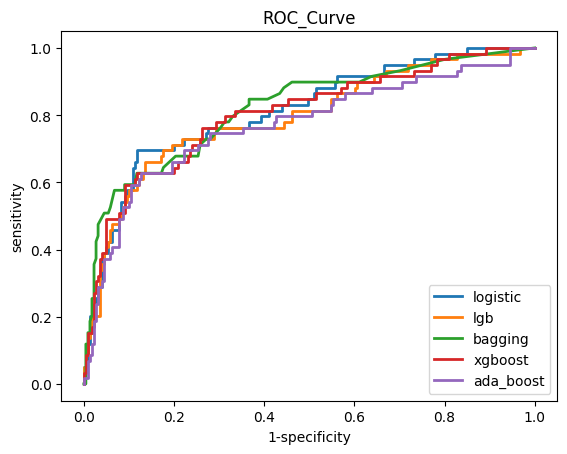

In [15]:
logistic_auc=PlotRocCurve(y_test,logistic.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='logistic')
lgb_auc=PlotRocCurve(y_test,lgb_model.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='lgb')
bagging_auc=PlotRocCurve(y_test,bag.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='bagging')
xgboost_auc=PlotRocCurve(y_test,xgboostModel.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='xgboost')
adaboost_auc=PlotRocCurve(y_test,ada_boost.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='ada_boost')
print(f"Logistic_AUC:{logistic_auc}")
print(f"LGBM_AUC:{lgb_auc}")
print(f"Bagging_AUC:{bagging_auc}")
print(f"XGBoost_AUC:{xgboost_auc}")
print(f"AdaBoost_AUC:{adaboost_auc}")